In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

### Dataset

In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [2]:
df_raw = pd.read_csv("./data/data.csv")

df = df_raw.copy()
df.drop(["Engine Fuel Type", "Driven_Wheels", "Number of Doors", "Market Category", "Vehicle Size", "Popularity"], axis = 1, inplace = True)

df.columns = df.columns.str.replace(' ', '_').str.lower()

df = df.fillna(0)

df.rename(columns={"msrp": "above_average"}, inplace = True)
df["above_average"].where(df["above_average"] < df.above_average.mean(), 1, inplace=True)
df["above_average"].where(df["above_average"] <= 1, 0, inplace=True)

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [3]:
numerical = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

for variable in numerical:
    auc = roc_auc_score(y_train, df_train[variable])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[variable])
    
    print(variable)
    print(auc)
    print()

year
0.687551492804683

engine_hp
0.9171031265539011

engine_cylinders
0.766116490165669

highway_mpg
0.6330587871772013

city_mpg
0.6734244643245233



### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [4]:
categorical = ["make", "model", "transmission_type", "vehicle_style"]

dv = DictVectorizer(sparse = False)

train_dict = df_train[categorical + numerical].to_dict(orient = "records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient = "records")
X_val = dv.transform(val_dict)

model = LogisticRegression(solver = "liblinear", C = 1.0, max_iter = 1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)

print(round(auc, 3))

0.977


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [5]:
accuracy_score(y_val, y_pred >= 0.5)

0.931598825010491

In [6]:
thresholds = np.linspace(0, 1, 101)
precision_values = []
recall_values = []

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    true_pos = (predict_positive & actual_positive).sum()
    true_neg = (predict_negative & actual_negative).sum()

    false_pos = (predict_positive & actual_negative).sum()
    false_neg = (predict_negative & actual_positive).sum()

    precision = true_pos / (true_pos + false_pos)
    precision_values.append(precision)

    recall = true_pos / (true_pos + false_neg)
    recall_values.append(recall)

/tmp/ipykernel_88014/94790123.py:18: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


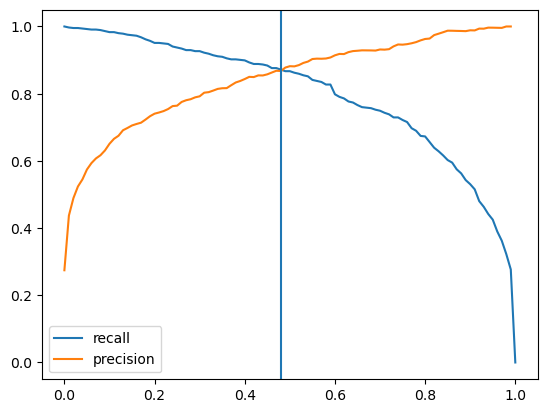

In [7]:
plt.plot(thresholds, recall_values, label = "recall")
plt.plot(thresholds, precision_values, label = "precision")
plt.axvline(x = 0.48)
plt.legend() 
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [8]:
thresholds = np.linspace(0, 1, 101)
f_scores = []
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    true_pos = (predict_positive & actual_positive).sum()
    true_neg = (predict_negative & actual_negative).sum()

    false_pos = (predict_positive & actual_negative).sum()
    false_neg = (predict_negative & actual_positive).sum()

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    F1 = 2 * ((precision * recall) / (precision + recall))

    print('%.2f %.3f' % (t, F1))
    f_scores.append(F1)

0.00 0.431
0.01 0.608
0.02 0.656
0.03 0.686
0.04 0.704
0.05 0.728
0.06 0.742
0.07 0.753
0.08 0.760
0.09 0.770
0.10 0.783
0.11 0.794
0.12 0.799
0.13 0.810
0.14 0.814
0.15 0.818
0.16 0.821
0.17 0.822
0.18 0.825
0.19 0.830
0.20 0.833
0.21 0.835
0.22 0.837
0.23 0.840
0.24 0.842
0.25 0.842
0.26 0.847
0.27 0.849
0.28 0.850
0.29 0.852
0.30 0.854
0.31 0.858
0.32 0.858
0.33 0.859
0.34 0.860
0.35 0.860
0.36 0.859
0.37 0.862
0.38 0.866
0.39 0.868
0.40 0.870
0.41 0.871
0.42 0.868
0.43 0.871
0.44 0.870
0.45 0.870
0.46 0.869
0.47 0.872
0.48 0.870
0.49 0.872
0.50 0.874
0.51 0.872
0.52 0.872
0.53 0.873
0.54 0.873
0.55 0.871
0.56 0.870
0.57 0.868
0.58 0.864
0.59 0.866
0.60 0.852
0.61 0.850
0.62 0.847
0.63 0.844
0.64 0.843
0.65 0.839
0.66 0.836
0.67 0.835
0.68 0.834
0.69 0.831
0.70 0.831
0.71 0.827
0.72 0.824
0.73 0.822
0.74 0.824
0.75 0.819
0.76 0.815
0.77 0.804
0.78 0.800
0.79 0.792
0.80 0.792
0.81 0.781
0.82 0.772
0.83 0.765
0.84 0.758
0.85 0.748
0.86 0.742
0.87 0.727
0.88 0.717
0.89 0.700
0.90 0.691

/tmp/ipykernel_88014/496968174.py:16: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


In [9]:
f_scores.index(max(f_scores))

50

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [10]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient = "records")

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver = "liblinear", C = 1.0, max_iter = 1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [11]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = "records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [12]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print((np.mean(scores), np.std(scores)))

(0.9783853646090865, 0.001370625504215498)


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [13]:
def train(df_train, y_train, C = 1.0):
    dicts = df_train[categorical + numerical].to_dict(orient = "records")

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver = "liblinear", C = C, max_iter = 1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [14]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = "records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [15]:
for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C = %s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C = 0.01 0.952 +- 0.002
C = 0.1 0.972 +- 0.001
C = 0.5 0.978 +- 0.003
C = 10 0.981 +- 0.002
